In [ ]:
! pip install pandas numpy tensorflow scikit-learn imbalanced-learn matplotlib seaborn

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# ==========================================
# 1. Configuration
# ==========================================
# Data Settings
DATA_PATH = '/Users/mostafazamaniturk/Documents/USD/AAI-530/work/aligned_wrist_data_64Hz_v1.csv'
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(os.getcwd(), 'aligned_wrist_data_64Hz_v1.csv')

WINDOW_SIZE_SEC = 30       # 30-second windows (shorter = more windows, esp. with sparse labels)
SAMPLING_RATE = 64         # 64 Hz
WINDOW_LENGTH = WINDOW_SIZE_SEC * SAMPLING_RATE  # 1920 samples
STRIDE = WINDOW_LENGTH // 2  # 50% Overlap

# Window label threshold: require at least this fraction of non-(-1) labels (0.2 = 20%)
# Lower = more windows but noisier; higher = fewer but purer windows
MIN_VALID_LABEL_RATIO = 0.2

# Classification: 'binary' = stress vs non-stress (0,1), '3class' = baseline/stress/amusement (0,1,2)
N_CLASSES = 2  # 2 = binary, 3 = 3-class

# Training Settings
BATCH_SIZE = 16            # Smaller batch for limited data
EPOCHS = 80                # Use early stopping; max epochs
LEARNING_RATE = 0.001
USE_CLASS_WEIGHTS = True   # Handle class imbalance
USE_OVERSAMPLING = True    # Oversample minority class when possible

# Early Stopping (stops when val_loss doesn't improve for this many epochs; increase to train longer)
EARLY_STOPPING_PATIENCE = 15  # e.g. 25–30 if you want more epochs before stopping

# The 11/2/2 Split (Hardcoded for reproducibility)
TRAIN_SUBJECTS = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13']
VAL_SUBJECTS   = ['S14', 'S15']
TEST_SUBJECTS  = ['S16', 'S17']

# Optional: path to CSV with NON-NORMALIZED bvp/eda for exporting test_S16.csv and test_S17.csv.
# If DATA_PATH contains normalized values, set this to your raw aligned CSV so test exports have original EDA/BVP.
RAW_DATA_PATH = '/Users/mostafazamaniturk/Documents/USD/AAI-530/work/aligned_wrist_data_64Hz.csv'

In [3]:
# ==========================================
# 2. Data Loading & Labeling
# ==========================================
def load_and_label_data(filepath):
    """
    Loads aligned BVP/EDA data. Uses real labels if 'label' column exists
    (0=baseline, 1=stress, 2=amusement, -1=other). Otherwise generates fallback labels.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found: {filepath}\n(Unzip aligned_wrist_data_64Hz.csv.zip if needed)")
    print("Loading data...")
    df = pd.read_csv(filepath)

    if 'label' in df.columns:
        print("Using real labels from CSV. Distribution:")
        print(df['label'].value_counts().sort_index())
        # Ensure int type
        df['label'] = df['label'].astype(int)
    else:
        print("No 'label' column found. Using fallback (first half=baseline, second half=stress)...")
        df['label'] = 0
        for sub in df['subject'].unique():
            sub_mask = df['subject'] == sub
            max_time = df.loc[sub_mask, 'time_sec'].max()
            df.loc[sub_mask & (df['time_sec'] > max_time / 2), 'label'] = 1

    return df


In [4]:
# ==========================================
# 3. Preprocessing (Normalization & Windowing)
# ==========================================
def _window_label(window_labels, n_classes, min_valid_ratio=0.2):
    """
    Majority vote for window. For 2-class: 0,2->0 (non-stress), 1->1 (stress).
    Skip windows where fewer than min_valid_ratio of samples have valid labels (non -1).
    """
    valid = window_labels[window_labels >= 0]  # exclude -1
    if len(valid) < len(window_labels) * min_valid_ratio:
        return None
    if n_classes == 2:
        # Map 2 (amusement) -> 0 (non-stress)
        valid = np.where(valid == 2, 0, valid)
        valid = valid[valid <= 1]  # keep only 0,1
        if len(valid) == 0:
            return None
    counts = np.bincount(valid.astype(int), minlength=n_classes)
    return int(np.argmax(counts))

def create_windows(df, subjects, n_classes=2, min_valid_ratio=None):
    """
    Slices data into fixed-length windows. Normalizes per subject (Z-Score).
    For 2-class: 0=non-stress (baseline+amusement), 1=stress.
    """
    if min_valid_ratio is None:
        min_valid_ratio = MIN_VALID_LABEL_RATIO
    X_windows, y_windows = [], []

    for sub in subjects:
        sub_df = df[df['subject'] == sub].copy()
        if sub_df.empty:
            continue

        scaler = StandardScaler()
        sub_df[['bvp', 'eda']] = scaler.fit_transform(sub_df[['bvp', 'eda']])
        data_arr = sub_df[['bvp', 'eda']].values
        label_arr = sub_df['label'].values
        num_samples = len(data_arr)

        for start in range(0, num_samples - WINDOW_LENGTH, STRIDE):
            end = start + WINDOW_LENGTH
            window_data = data_arr[start:end]
            window_labels = label_arr[start:end]
            lbl = _window_label(window_labels, n_classes, min_valid_ratio)
            if lbl is not None:
                X_windows.append(window_data)
                y_windows.append(lbl)

    return np.array(X_windows) if X_windows else np.array([]).reshape(0, WINDOW_LENGTH, 2), \
           np.array(y_windows) if y_windows else np.array([])

def get_window_metadata(df, subjects, n_classes=2, min_valid_ratio=None):
    """Returns a list of dicts (subject, window_start_sec, window_end_sec, true_label) in the same order as create_windows. Use to attach predictions to window-level rows for export."""
    if min_valid_ratio is None:
        min_valid_ratio = MIN_VALID_LABEL_RATIO
    meta = []
    for sub in subjects:
        sub_df = df[df['subject'] == sub].copy()
        if sub_df.empty:
            continue
        label_arr = sub_df['label'].values
        time_arr = sub_df['time_sec'].values
        num_samples = len(label_arr)
        for start in range(0, num_samples - WINDOW_LENGTH, STRIDE):
            end = start + WINDOW_LENGTH
            window_labels = label_arr[start:end]
            lbl = _window_label(window_labels, n_classes, min_valid_ratio)
            if lbl is not None:
                meta.append({
                    'subject': sub,
                    'window_start_sec': float(time_arr[start]),
                    'window_end_sec': float(time_arr[end - 1]),
                    'true_label': lbl
                })
    return meta

In [5]:
# ==========================================
# 4. Model Architecture (1D-CNN)
# ==========================================
def build_1d_cnn(input_shape, n_classes=2):
    """Lightweight 1D-CNN for BVP/EDA. n_classes=2 (stress vs non-stress) or 3 (baseline/stress/amusement)."""
    inputs = layers.Input(shape=input_shape)

    # Adjusted kernel sizes for shorter windows (e.g., 30s = 1920 samples)
    k1 = min(64, input_shape[0] // 30)
    k2 = min(32, input_shape[0] // 60)
    k3 = min(16, input_shape[0] // 120)

    x = layers.Conv1D(filters=32, kernel_size=k1, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=4)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(filters=64, kernel_size=k2, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=4)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(filters=128, kernel_size=k3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
# ==========================================
# 5. Main Execution Pipeline
# ==========================================
# A. Load Data
df = load_and_label_data(DATA_PATH)
# Keep a copy of raw (pre-normalization) data for exporting S16/S17 with original EDA/BVP values
df_raw = df[['subject', 'time_sec', 'bvp', 'eda', 'label']].copy()

# B. Create Datasets (Train / Val / Test)
print(f"\nCreating windows ({WINDOW_SIZE_SEC}s, {N_CLASSES}-class, min_valid_ratio={MIN_VALID_LABEL_RATIO})...")
X_train, y_train = create_windows(df, TRAIN_SUBJECTS, n_classes=N_CLASSES)
X_val, y_val     = create_windows(df, VAL_SUBJECTS, n_classes=N_CLASSES)
X_test, y_test   = create_windows(df, TEST_SUBJECTS, n_classes=N_CLASSES)

print(f"Train Shape: {X_train.shape} (Subjects: {len(TRAIN_SUBJECTS)})")
print(f"Val Shape:   {X_val.shape}   (Subjects: {len(VAL_SUBJECTS)})")
print(f"Test Shape:  {X_test.shape}  (Subjects: {len(TEST_SUBJECTS)})")
class_names = ['non-stress', 'stress'] if N_CLASSES == 2 else ['baseline', 'stress', 'amusement']

if len(X_train) == 0:
    raise ValueError("No training windows generated. Try lowering MIN_VALID_LABEL_RATIO or check subject split.")
train_counts = np.bincount(y_train.astype(int), minlength=N_CLASSES)
print(f"Train class distribution: {dict(zip(class_names, train_counts))}")

# Check for missing classes
missing = [c for c in range(N_CLASSES) if train_counts[c] == 0]
if missing:
    print(f"\n⚠️  Warning: No training samples for class(es) {missing}. Model cannot learn these classes.")
    print("   Consider: lowering MIN_VALID_LABEL_RATIO, using different subject split, or 3-class mode.")

# C. Class Weights & Oversampling
class_weight = None
if USE_CLASS_WEIGHTS and len(np.unique(y_train)) > 1:
    cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight = dict(zip(np.unique(y_train), cw))
    print(f"\nClass weights (for imbalance): {class_weight}")

if USE_OVERSAMPLING and len(X_train) > 0 and len(np.unique(y_train)) > 1:
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    n_samples, n_timesteps, n_features = X_train.shape
    X_flat = X_train.reshape(n_samples, -1)
    X_flat, y_train = ros.fit_resample(X_flat, y_train)
    X_train = X_flat.reshape(-1, n_timesteps, n_features)
    print(f"After oversampling - Train shape: {X_train.shape}, class dist: {np.bincount(y_train.astype(int))}")

# D. Build Model & Callbacks
input_shape = (WINDOW_LENGTH, 2)
model = build_1d_cnn(input_shape, n_classes=N_CLASSES)
model.summary()

save_path = os.path.join(os.path.dirname(DATA_PATH), 'wesad_1d_cnn_best.keras')
has_val = len(X_val) > 0
monitor = 'val_loss' if has_val else 'loss'
cb = [
    callbacks.EarlyStopping(
        monitor=monitor, patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1
    ),
    callbacks.ModelCheckpoint(save_path, monitor=monitor, save_best_only=True, verbose=0)
]

# E. Train
print("\nStarting Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val) if has_val else None,
    epochs=EPOCHS,
    batch_size=min(BATCH_SIZE, len(X_train)),
    class_weight=class_weight,
    callbacks=cb,
    verbose=1
)

# F. Final Evaluation
print("\nEvaluating on Test Set (Unseen Subjects)...")
if len(X_test) > 0:
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")

    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Test Balanced Accuracy: {bal_acc:.4f} (better metric for imbalanced data)")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, labels=range(N_CLASSES), target_names=class_names, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred, labels=range(N_CLASSES)))

    # Export dataset with predicted_stress for Tableau dashboard
    test_meta = get_window_metadata(df, TEST_SUBJECTS, n_classes=N_CLASSES)
    df_export = pd.DataFrame(test_meta)
    df_export['predicted_stress'] = y_pred  # 0=non-stress, 1=stress
    df_export['predicted_stress_label'] = df_export['predicted_stress'].map({0: 'non-stress', 1: 'stress'} if N_CLASSES == 2 else {0: 'baseline', 1: 'stress', 2: 'amusement'})
    df_export['time_sec'] = df_export['window_start_sec']  # time in seconds for Tableau
    # Add datetime column YYYY-MM-DD HH:MM:SS (reference: 2000-01-01 00:00:00 + time_sec)
    from datetime import datetime, timedelta
    ref_start = datetime(2000, 1, 1, 0, 0, 0)
    df_export['time'] = df_export['time_sec'].apply(lambda s: (ref_start + timedelta(seconds=float(s))).strftime('%Y-%m-%d %H:%M:%S'))
    export_path = os.path.join(os.path.dirname(DATA_PATH), 'stress_predictions_for_tableau.csv')
    df_export.to_csv(export_path, index=False)
    print(f"\nDataset with predictions saved to {export_path} ({len(df_export)} rows)")

    # Export test set S16 and S17: use RAW_DATA_PATH for non-normalized bvp/eda if set, else DATA_PATH
    out_dir = os.path.dirname(DATA_PATH)
    pred_map = {0: 'non-stress', 1: 'stress'} if N_CLASSES == 2 else {0: 'baseline', 1: 'stress', 2: 'amusement'}
    windows_list = [(m['subject'], m['window_start_sec'], m['window_end_sec'], y_pred[i]) for i, m in enumerate(test_meta)]
    export_data_path = RAW_DATA_PATH if (RAW_DATA_PATH and os.path.exists(RAW_DATA_PATH)) else DATA_PATH
    if export_data_path != DATA_PATH:
        print(f"Using raw data for test export: {export_data_path}")
    else:
        print("Using DATA_PATH for test export (set RAW_DATA_PATH to a non-normalized CSV if test_S16/S17 should have original EDA/BVP).")
    df_export_source = pd.read_csv(export_data_path)[['subject', 'time_sec', 'bvp', 'eda', 'label']]
    for sub in TEST_SUBJECTS:
        df_sub = df_export_source.loc[df_export_source['subject'] == sub].copy()
        if df_sub.empty:
            continue
        sub_windows = [(s, e, p) for sb, s, e, p in windows_list if sb == sub]
        def assign_pred(t):
            for (start, end, pred) in sub_windows:
                if start <= t < end: return pred
            return -1
        df_sub['predicted_label'] = df_sub['time_sec'].apply(assign_pred)
        df_sub['predicted_label_name'] = df_sub['predicted_label'].map(lambda x: pred_map.get(x, 'no_window'))
        csv_path = os.path.join(out_dir, f'test_{sub}.csv')
        df_sub.to_csv(csv_path, index=False)
        label_suffix = "original EDA/BVP" if (RAW_DATA_PATH and export_data_path == RAW_DATA_PATH) else "bvp/eda from " + os.path.basename(export_data_path)
        print(f"Saved test set {sub} to {csv_path} ({len(df_sub)} rows, {label_suffix})")
else:
    print("No test samples. Skipping evaluation.")

final_path = os.path.join(os.path.dirname(DATA_PATH), 'wesad_1d_cnn.keras')
model.save(final_path)
print(f"\nModel saved to {final_path}")

Loading data...
Using real labels from CSV. Distribution:
label
-1    3387163
 0    1147053
 1     655346
 2     369990
Name: count, dtype: int64

Creating windows (30s, 2-class, min_valid_ratio=0.2)...
Train Shape: (1691, 1920, 2) (Subjects: 11)
Val Shape:   (309, 1920, 2)   (Subjects: 2)
Test Shape:  (314, 1920, 2)  (Subjects: 2)
Train class distribution: {'non-stress': np.int64(1183), 'stress': np.int64(508)}

Class weights (for imbalance): {np.int64(0): np.float64(0.7147083685545224), np.int64(1): np.float64(1.6643700787401574)}
After oversampling - Train shape: (2366, 1920, 2), class dist: [1183 1183]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1920, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1920, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 480, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 480, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 480, 64)        │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 120, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,330 (825.51 KB)

 Trainable params: 211,330 (825.51 KB)

 Non-trainable params: 0 (0.00 B)


Starting Training...
Epoch 1/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9227 - loss: 0.2381 - val_accuracy: 0.9223 - val_loss: 0.1450
Epoch 2/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9383 - loss: 0.1760 - val_accuracy: 0.9126 - val_loss: 0.1493
Epoch 3/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9497 - loss: 0.1483 - val_accuracy: 0.8900 - val_loss: 0.1663
Epoch 4/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9480 - loss: 0.1338 - val_accuracy: 0.8738 - val_loss: 0.1960
Epoch 5/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9569 - loss: 0.1010 - val_accuracy: 0.9320 - val_loss: 0.1517
Epoch 6/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9607 - loss: 0.1138 - val_accuracy: 0.8803 - val_loss: 0.2243
Epoch 7/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9573 - loss: 0.0894 - val_accuracy: 0.8964 - val_loss: 0.1676
Epoch 8/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9721 - l

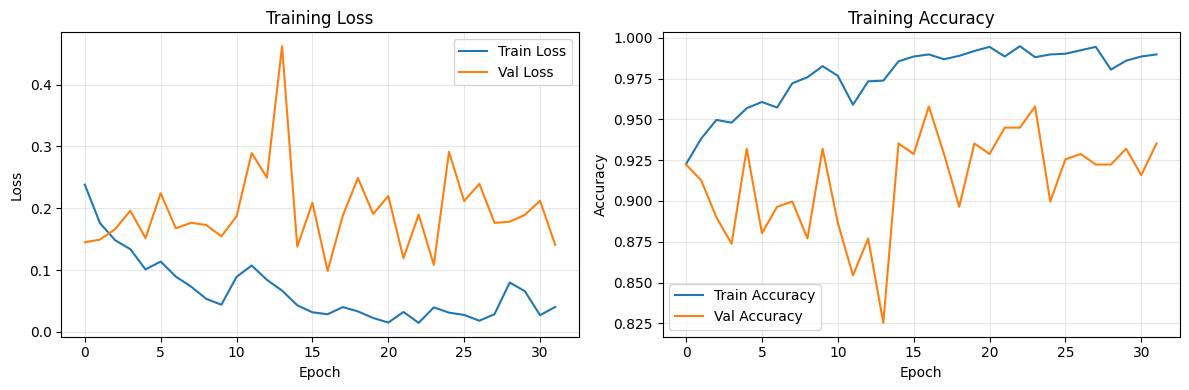

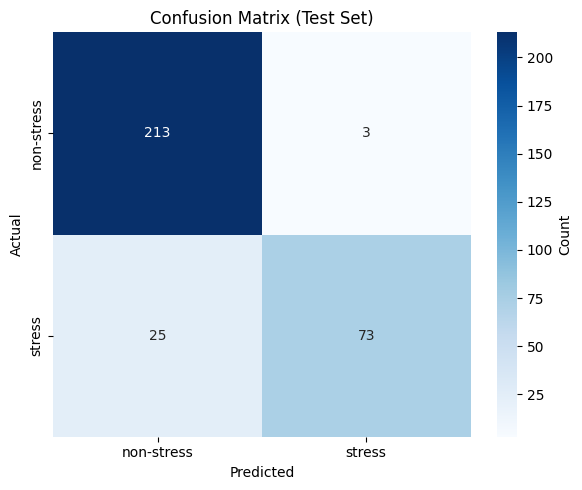


RESULTS SUMMARY
Test Accuracy:        0.9108
Balanced Accuracy:    0.8655
Weighted Precision:   0.9154
Weighted Recall:      0.9108
Weighted F1-Score:    0.9074


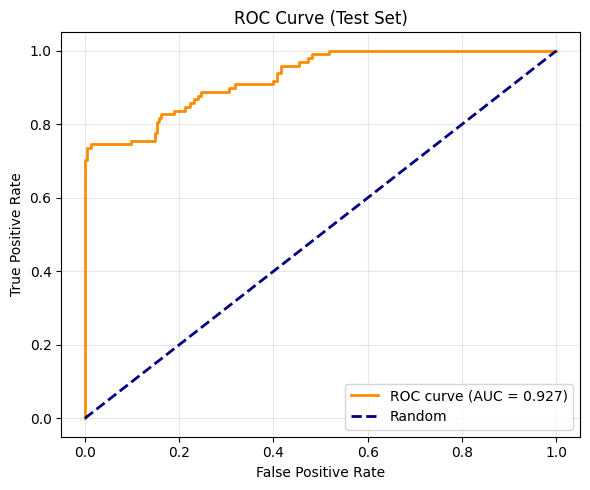

In [7]:
# ==========================================
# 6. Visualize Results
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Training History (Loss & Accuracy)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Confusion Matrix Heatmap (on Test Set)
if len(X_test) > 0:
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    cm = confusion_matrix(y_test, y_pred, labels=range(N_CLASSES))
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.show()

    # 3. Summary Metrics
    from sklearn.metrics import precision_recall_fscore_support
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    print("\n" + "="*50)
    print("RESULTS SUMMARY")
    print("="*50)
    print(f"Test Accuracy:        {test_acc:.4f}")
    print(f"Balanced Accuracy:    {bal_acc:.4f}")
    print(f"Weighted Precision:   {prec:.4f}")
    print(f"Weighted Recall:      {rec:.4f}")
    print(f"Weighted F1-Score:    {f1:.4f}")
    print("="*50)

    # 4. ROC Curve (binary classification)
    if N_CLASSES == 2:
        from sklearn.metrics import roc_curve, roc_auc_score
        y_proba = model.predict(X_test, verbose=0)[:, 1]  # P(stress)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve (Test Set)')
        ax.legend(loc='lower right')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [ ]:
# ==========================================
# Add column: average heart rate of 5 minutes ago — using s16-BVP_with_TimeDate_HR.csv
# ==========================================
import pandas as pd
import numpy as np
import os

# Dataset: s16-BVP_with_TimeDate_HR.csv (columns: BVP, time_sec, TimeDate, Heart_Rate_BPM)
DATA_PATH_S16 = '/Users/mostafazamaniturk/Documents/USD/AAI-530/work/s16-BVP_with_TimeDate_HR.csv'
if not os.path.exists(DATA_PATH_S16):
    DATA_PATH_S16 = os.path.join(os.getcwd(), 's16-BVP_with_TimeDate_HR.csv')
if not os.path.exists(DATA_PATH_S16):
    DATA_PATH_S16 = os.path.join(os.path.dirname(os.getcwd()), 's16-BVP_with_TimeDate_HR.csv')

FS = 64
WINDOW_5MIN_SAMPLES = 5 * 60 * FS  # 5 minutes at 64 Hz = 19200 samples

print("Loading s16-BVP_with_TimeDate_HR.csv...")
df_out = pd.read_csv(DATA_PATH_S16)
# Ensure time_sec is numeric and sorted (single subject S16)
df_out['time_sec'] = pd.to_numeric(df_out['time_sec'], errors='coerce')
df_out = df_out.sort_values('time_sec').reset_index(drop=True)

if 'Heart_Rate_BPM' not in df_out.columns:
    raise ValueError("s16-BVP_with_TimeDate_HR.csv must contain column 'Heart_Rate_BPM'. Run the neurokit2 BVP cell first.")

print("Computing average heart rate of 5 minutes ago...")
df_out['avg_heart_rate_5min_ago'] = df_out['Heart_Rate_BPM'].rolling(
    window=WINDOW_5MIN_SAMPLES, min_periods=1
).mean()

out_dir = os.path.dirname(DATA_PATH_S16)
export_path = os.path.join(out_dir, 's16-BVP_with_TimeDate_HR_avgHR5min.csv')
df_out.to_csv(export_path, index=False)
print(f"Exported {len(df_out):,} rows to: {export_path}")

cols_preview = [c for c in ['time_sec', 'BVP', 'Heart_Rate_BPM', 'avg_heart_rate_5min_ago', 'TimeDate'] if c in df_out.columns]
print(df_out[cols_preview].head(10))

In [8]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURATION
# ==========================================
WINDOW_SIZE_SEC = 60
FS = 64
WINDOW_LEN = WINDOW_SIZE_SEC * FS
STRIDE = WINDOW_LEN // 2  # 50% Overlap

# Load your aligned data (if not already loaded)
df_all = pd.read_csv('/Users/mostafazamaniturk/Documents/USD/AAI-530/work/aligned_wrist_data_64Hz_v1.csv')

# Filter for Test Subjects only (User View)
test_subjects = ['S16', 'S17']
df_test = df_all[df_all['subject'].isin(test_subjects)].copy()

# ==========================================
# 1. CALCULATE HEART RATE (BPM) FROM BVP
# ==========================================
def get_bpm(bvp_signal, fs=64):
    # Smooth signal slightly to remove high-freq noise
    smooth_bvp = pd.Series(bvp_signal).rolling(window=5, center=True).mean().fillna(0).values
    
    # Find peaks (Heartbeats)
    # distance=30 samples (~0.5s) implies max HR of ~120 BPM (conservative)
    peaks, _ = find_peaks(smooth_bvp, distance=30, prominence=10)
    
    # Calculate BPM array (same length as signal)
    bpm_series = np.full(len(bvp_signal), np.nan)
    
    if len(peaks) > 1:
        # Diff between peaks in seconds
        peak_diffs_sec = np.diff(peaks) / fs
        # Instantaneous BPM
        instant_bpm = 60.0 / peak_diffs_sec
        
        # Assign BPM to the peak location
        bpm_series[peaks[1:]] = instant_bpm
        
    # Interpolate to fill gaps between beats
    return pd.Series(bpm_series).interpolate(method='linear').ffill().bfill().values

print("Calculating Heart Rate (BPM)...")
df_test['Heart_Rate_BPM'] = df_test.groupby('subject')['bvp'].transform(lambda x: get_bpm(x.values))

# ==========================================
# 2. CALCULATE SMOOTHED EDA (STRESS INDEX)
# ==========================================
# Smooth EDA over 5 seconds to remove small artifacts
print("Calculating Stress Index (Smoothed EDA)...")
df_test['Stress_Index_EDA'] = df_test.groupby('subject')['eda'].transform(
    lambda x: x.rolling(window=64*5, center=True).mean().bfill().ffill()
)

# ==========================================
# 3. GENERATE MODEL PREDICTIONS
# ==========================================
print("Running AI Model predictions...")

# Initialize Prediction Column
df_test['Stress_Probability'] = 0.0

# Iterate through subjects to predict on windows
for sub in test_subjects:
    sub_mask = df_test['subject'] == sub
    sub_data = df_test[sub_mask].copy()
    
    # We need to normalize this subject just like in training!
    # (Assuming you fit a scaler earlier, use that. If not, fit new one for demo)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    norm_data = scaler.fit_transform(sub_data[['bvp', 'eda']])
    
    # Slide window
    num_samples = len(norm_data)
    for i in range(0, num_samples - WINDOW_LEN, STRIDE):
        # Extract Window
        window = norm_data[i : i + WINDOW_LEN]
        window = window.reshape(1, WINDOW_LEN, 2)
        
        # Predict (Returns prob between 0 and 1)
        prob = model.predict(window, verbose=0)[0][0]
        
        # Assign this probability to the time range in the dataframe
        # (This expands the single prediction to the whole 60s window)
        # Note: Overlaps will be overwritten by the later window (which is fine for trends)
        df_test.loc[sub_data.index[i : i + WINDOW_LEN], 'Stress_Probability'] = prob

# ==========================================
# 4. EXPORT FOR TABLEAU
# ==========================================
output_file = 'vitalguard_tableau.csv'
df_test.to_csv(output_file, index=False)
print(f"Success! Data saved to: {output_file}")
print(df_test[['subject', 'time_sec', 'Heart_Rate_BPM', 'Stress_Probability']].head())


Calculating Heart Rate (BPM)...
Calculating Stress Index (Smoothed EDA)...
Running AI Model predictions...
Success! Data saved to: vitalguard_tableau.csv
        subject  time_sec  Heart_Rate_BPM  Stress_Probability
4820288     S16  0.000000       68.571429                 1.0
4820289     S16  0.015625       68.571429                 1.0
4820290     S16  0.031250       68.571429                 1.0
4820291     S16  0.046875       68.571429                 1.0
4820292     S16  0.062500       68.571429                 1.0


In [ ]:
# 

In [9]:
# ==========================================
# Add stress label from threshold: >70 = stress (1), <=70 = non-stress (0)
# and export vitalguard_tableau with new configuration
# ==========================================
import pandas as pd
import os

# Path to vitalguard_tableau.csv (current dir or parent)
TABLEAU_CSV = os.path.join(os.getcwd(), 'vitalguard_tableau.csv')
if not os.path.exists(TABLEAU_CSV):
    TABLEAU_CSV = os.path.join(os.path.dirname(os.getcwd()), 'vitalguard_tableau.csv')
if not os.path.exists(TABLEAU_CSV):
    TABLEAU_CSV = 'vitalguard_tableau.csv'

df_vg = pd.read_csv(TABLEAU_CSV)
THRESHOLD = 70   # values > 70 → stress (1), <= 70 → non-stress (0)

# Choose column to threshold: prefer Stress_Level (0-100), else Heart_Rate (BPM), else Stress_Probability (0-1 → use 0.7)
if 'Stress_Level' in df_vg.columns:
    value_col = 'Stress_Level'
    thresh = THRESHOLD
elif 'Heart_Rate' in df_vg.columns:
    value_col = 'Heart_Rate'
    thresh = THRESHOLD
elif 'Stress_Probability' in df_vg.columns:
    value_col = 'Stress_Probability'
    thresh = 0.70   # 70% probability
else:
    raise ValueError("Need one of: Stress_Level, Heart_Rate, Stress_Probability")

# Binary label: 1 = stress, 0 = non-stress
df_vg['stress_label'] = (df_vg[value_col] > thresh).astype(int)
df_vg['stress_label_name'] = df_vg['stress_label'].map({1: 'stress', 0: 'non-stress'})

# Export with new configuration
out_path = os.path.join(os.path.dirname(TABLEAU_CSV), 'vitalguard_tableau_labeled.csv')
df_vg.to_csv(out_path, index=False)
print(f"Threshold: {value_col} > {thresh} → stress (1), else non-stress (0)")
print(f"Exported {len(df_vg)} rows to: {out_path}")
print(df_vg[['stress_label', 'stress_label_name', value_col]].head(10))

Threshold: Stress_Level > 70 → stress (1), else non-stress (0)
Exported 200 rows to: /Users/mostafazamaniturk/Documents/USD/AAI-530/work/edaFolder/1d-cnn/vitalguard_tableau_labeled.csv
   stress_label stress_label_name  Stress_Level
0             0        non-stress            15
1             0        non-stress            29
2             0        non-stress            20
3             0        non-stress            14
4             0        non-stress            14
5             0        non-stress            24
6             0        non-stress            11
7             0        non-stress            29
8             0        non-stress            16
9             0        non-stress            26


In [2]:
# Add TimeDate column to s16-IBI.csv (S16)
# IBI CSV: first row = start Unix timestamp + " IBI"; rest = elapsed_sec, IBI

import pandas as pd
import os

# Data Settings
DATA_PATH_IBI = '/Users/mostafazamaniturk/Documents/USD/AAI-530/work/s16-IBI.csv'
if not os.path.exists(DATA_PATH_IBI):
    DATA_PATH_IBI = os.path.join(os.getcwd(), 's16-IBI.csv')

# First row contains start Unix timestamp; remaining rows = elapsed_sec, IBI
raw = pd.read_csv(DATA_PATH_IBI, header=None)
start_unix = float(raw.iloc[0, 0])
df_ibi = raw.iloc[1:].copy()
df_ibi.columns = ['time_sec', 'IBI']
df_ibi['time_sec'] = pd.to_numeric(df_ibi['time_sec'], errors='coerce')
df_ibi['IBI'] = pd.to_numeric(df_ibi['IBI'], errors='coerce')
df_ibi = df_ibi.dropna()

# Add TimeDate: start timestamp + elapsed seconds
df_ibi['TimeDate'] = pd.to_datetime(start_unix + df_ibi['time_sec'], unit='s')

# Export with TimeDate
out_path = os.path.join(os.path.dirname(DATA_PATH_IBI), 's16-IBI_with_TimeDate.csv')
df_ibi.to_csv(out_path, index=False)
print(f'Saved: {out_path}')
df_ibi.head(10)



Saved: /Users/mostafazamaniturk/Documents/USD/AAI-530/work/s16-IBI_with_TimeDate.csv


,time_sec,IBI,TimeDate
1,13.641249,0.906291,2017-08-10 11:59:38.641248941
2,14.656921,1.015671,2017-08-10 11:59:39.656920910
3,15.656967,1.000046,2017-08-10 11:59:40.656966925
4,16.516381,0.859414,2017-08-10 11:59:41.516381025
5,17.422673,0.906291,2017-08-10 11:59:42.422672987
6,18.328964,0.906291,2017-08-10 11:59:43.328963995
7,25.641799,0.953169,2017-08-10 11:59:50.641798973
8,26.594967,0.953169,2017-08-10 11:59:51.594966888
9,27.438756,0.843789,2017-08-10 11:59:52.438755989
10,28.329422,0.890666,2017-08-10 11:59:53.329421997


In [ ]:
%pip install neurokit2

In [12]:
# Add TimeDate and Heart Rate (BPM) to s16-BVP.csv (S16)
# BVP CSV: first row = start Unix timestamp; rest = elapsed_sec, BVP (or BVP only)
# Uses neurokit2 to derive continuous heart rate from BVP (64 Hz).

import pandas as pd
import numpy as np
import os
import neurokit2 as nk

# Data Settings
DATA_PATH_BVP = '/Users/mostafazamaniturk/Documents/USD/AAI-530/work/s16-BVP.csv'
if not os.path.exists(DATA_PATH_BVP):
    DATA_PATH_BVP = os.path.join(os.getcwd(), 's16-BVP.csv')

# First row contains start Unix timestamp; remaining rows = elapsed_sec, BVP (or BVP only)
raw_bvp = pd.read_csv(DATA_PATH_BVP, header=None)
start_unix_bvp = float(raw_bvp.iloc[0, 0])
df_bvp = raw_bvp.iloc[1:].copy()
n_cols = df_bvp.shape[1]
if n_cols == 2:
    df_bvp.columns = ['time_sec', 'BVP']
    df_bvp['time_sec'] = pd.to_numeric(df_bvp['time_sec'], errors='coerce')
    df_bvp['BVP'] = pd.to_numeric(df_bvp['BVP'], errors='coerce')
else:
    # Single column = BVP only; build time_sec from sample index (64 Hz)
    df_bvp.columns = ['BVP']
    df_bvp['BVP'] = pd.to_numeric(df_bvp['BVP'], errors='coerce')
    df_bvp['time_sec'] = np.arange(len(df_bvp)) / 64.0
df_bvp = df_bvp.dropna()

# Add TimeDate: start timestamp + elapsed seconds
df_bvp['TimeDate'] = pd.to_datetime(start_unix_bvp + df_bvp['time_sec'], unit='s')

# Heart rate (BPM) from BVP using neurokit2 (64 Hz)
raw_bvp_data = df_bvp['BVP'].values
signals, info = nk.ppg_process(raw_bvp_data, sampling_rate=64)
heart_rate_bpm = signals["PPG_Rate"]
df_bvp['Heart_Rate_BPM'] = heart_rate_bpm.values

# Export dataset with TimeDate and Heart_Rate_BPM
out_path_bvp = os.path.join(os.path.dirname(DATA_PATH_BVP), 's16-BVP_with_TimeDate_HR.csv')
df_bvp.to_csv(out_path_bvp, index=False)
print(f'Saved: {out_path_bvp}')
print(df_bvp[['time_sec', 'BVP', 'Heart_Rate_BPM', 'TimeDate']].head(10))
df_bvp.head(10)


Saved: /Users/mostafazamaniturk/Documents/USD/AAI-530/work/s16-BVP_with_TimeDate_HR.csv
    time_sec   BVP  Heart_Rate_BPM                   TimeDate
1   0.000000  64.0       68.675169 2017-08-10 11:59:25.000000
2   0.015625  -0.0       68.675169 2017-08-10 11:59:25.015625
3   0.031250  -0.0       68.675169 2017-08-10 11:59:25.031250
4   0.046875  -0.0       68.675169 2017-08-10 11:59:25.046875
5   0.062500  -0.0       68.675169 2017-08-10 11:59:25.062500
6   0.078125  -0.0       68.675169 2017-08-10 11:59:25.078125
7   0.093750  -0.0       68.675169 2017-08-10 11:59:25.093750
8   0.109375  -0.0       68.675169 2017-08-10 11:59:25.109375
9   0.125000  -0.0       68.675169 2017-08-10 11:59:25.125000
10  0.140625  -0.0       68.675169 2017-08-10 11:59:25.140625


,BVP,time_sec,TimeDate,Heart_Rate_BPM
1,64.0,0.000000,2017-08-10 11:59:25.000000,68.675169
2,-0.0,0.015625,2017-08-10 11:59:25.015625,68.675169
3,-0.0,0.031250,2017-08-10 11:59:25.031250,68.675169
4,-0.0,0.046875,2017-08-10 11:59:25.046875,68.675169
5,-0.0,0.062500,2017-08-10 11:59:25.062500,68.675169
6,-0.0,0.078125,2017-08-10 11:59:25.078125,68.675169
7,-0.0,0.093750,2017-08-10 11:59:25.093750,68.675169
8,-0.0,0.109375,2017-08-10 11:59:25.109375,68.675169
9,-0.0,0.125000,2017-08-10 11:59:25.125000,68.675169
10,-0.0,0.140625,2017-08-10 11:59:25.140625,68.675169


In [13]:
df_bvp.tail(10)


,BVP,time_sec,TimeDate,Heart_Rate_BPM
454842,-40.99,7106.890625,2017-08-10 13:57:51.890625,75.294118
454843,-40.38,7106.906250,2017-08-10 13:57:51.906250,75.294118
454844,-39.92,7106.921875,2017-08-10 13:57:51.921875,75.294118
454845,-39.58,7106.937500,2017-08-10 13:57:51.937500,75.294118
454846,-39.19,7106.953125,2017-08-10 13:57:51.953125,75.294118
454847,-38.49,7106.968750,2017-08-10 13:57:51.968750,75.294118
454848,-37.29,7106.984375,2017-08-10 13:57:51.984375,75.294118
454849,-35.53,7107.000000,2017-08-10 13:57:52.000000,75.294118
454850,-33.35,7107.015625,2017-08-10 13:57:52.015625,75.294118
454851,-31.04,7107.031250,2017-08-10 13:57:52.031250,75.294118
